In [1]:
import numpy as np
def read_data(file):
    data=[]
    with open(file,'r',encoding='utf-8') as f:
        for line in (f.readlines()):
            line = line.strip().replace(' ', '')
            data.append(line)
    return data
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/__notebook_source__.ipynb


In [2]:
data=read_data("/kaggle/input/dataset/clr_conversation.txt")
print(len(data))
data[:5]

2842478


['美國2500萬名老兵致敬', '我尤其高興能回到家鄉', '對我家裡的兩名老兵致敬', '家父,前任參議員亨利謝登', '和我弟弟華利謝登']

In [3]:
def load_dictionary(vocab_name):
    print ('loading dictionary')
    vocab, rev_vocab = {}, {}
    with open(vocab_name, 'r',encoding='utf-8') as fin:
        for line in fin:
            i, w = line.strip().split()
            vocab[str(w)] = int(i)
            rev_vocab[int(i)] = str(w)
    return vocab,rev_vocab
vocab,rev_vocab=load_dictionary('/kaggle/input/dataset/vocab.txt')
print(len(vocab))

loading dictionary
3000


In [4]:
def sentence_to_id(sentence,vocab):
    return [int(vocab.get(w, vocab.get('<UNK>'))) for w in sentence]

def prepare_text_data(text,max_length,vocab):
        text_id = []
        text_weight = []
        for data in text:
            sentence = sentence_to_id(data,vocab)
            if len(sentence) >= max_length:
                text_weight.append(max_length)
                text_id.append(sentence[:max_length-1] + [vocab.get('<EOS>')])
            else:
                text_weight.append(len(sentence)+1)
                text_id.append(sentence + [vocab.get('<EOS>')] + [vocab.get('<PAD>')]*(max_length-1-len(sentence)))
        text_id = np.asarray(text_id)
        text_weight = np.asarray(text_weight)
        return text_id,text_weight

In [5]:
text_id,text_weight=prepare_text_data(data,30,vocab)

In [6]:
text_id=np.hstack((np.ones((text_id.shape[0],1)),text_id))
text_id=np.array(text_id,dtype=np.int64)

In [7]:
import pickle
with open('text_id.npy', 'wb') as f:
    np.save(f, text_id)
with open('text_weight.pkl','wb') as f:
     pickle.dump(text_weight, f)

In [8]:
import tensorflow as tf

In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
from tensorflow.keras.layers import Embedding,Input,LSTM,TimeDistributed,Embedding,Dense,GRU,Bidirectional

2 (1, 100) (1, 100)


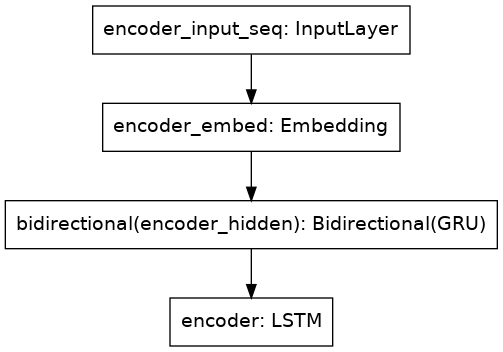

In [11]:
#encoder
enc_input = Input((31,), name = 'encoder_input_seq')
enc_embed = Embedding(len(vocab) + 1, 150, name = 'encoder_embed',mask_zero=True)(enc_input)
hidden = Bidirectional(GRU(100, return_sequences=True, name = 'encoder_hidden'))(enc_embed)
enc_z, enc_state_h, enc_state_c= LSTM(100, name = 'encoder',return_sequences=False,return_state=True)(hidden)

enc_model=tf.keras.Model(enc_input, [enc_state_h, enc_state_c])

test_enc=enc_model.predict(text_id[0].reshape(1,31,1))
print(len(test_enc),test_enc[0].shape,test_enc[1].shape)

tf.keras.utils.plot_model(enc_model)

(1, 30, 3000) (1, 100) (1, 100)


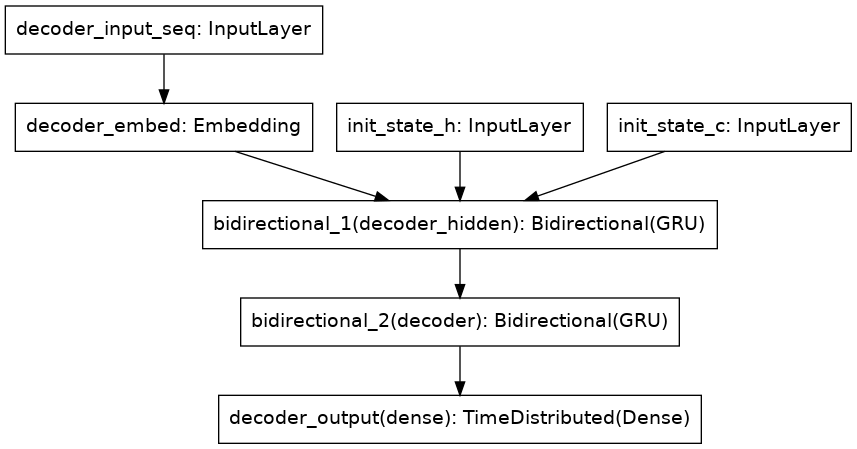

In [12]:
# decoder model
dec_input = Input((30,), name = 'decoder_input_seq')
dec_state_h=Input((100,), name = 'init_state_h')
dec_state_c=Input((100,), name = 'init_state_c')
decoder_states_inputs = [dec_state_h, dec_state_c]
dec_embed = Embedding(len(vocab) + 1, 150, name = 'decoder_embed',mask_zero=True)(dec_input)

dec_hidden = Bidirectional(GRU(100, return_sequences=True, name = 'decoder_hidden'))
decoder = Bidirectional(GRU(100, return_state=True, return_sequences=True, name = 'decoder'))
timedistributed=TimeDistributed(Dense(len(vocab), activation='softmax'), name = 'decoder_output')

build_decoder=dec_hidden(dec_embed,initial_state = [dec_state_h, dec_state_c])
build_all=  dec_hidden(dec_embed,initial_state = enc_model.outputs)
dec_z, dec_state_h, dec_state_c = decoder(build_decoder)
dec_z_all, dec_state_h_all, dec_state_c_all = decoder(build_all)
dec_fc = timedistributed(dec_z)
dec_fc_all = timedistributed(dec_z_all)

decoder_model= tf.keras.Model([dec_input]+decoder_states_inputs,[dec_fc,dec_state_h, dec_state_c])

inspect=decoder_model.predict([text_id[1][:-1].reshape(1,30,1),test_enc[0],test_enc[1]])
print(inspect[0].shape,inspect[1].shape,inspect[2].shape)
tf.keras.utils.plot_model(decoder_model)

In [13]:
enc_dec_model = tf.keras.Model([enc_input, dec_input], dec_fc_all)
enc_dec_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["accuracy"])
enc_dec_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_seq (InputLayer)  [(None, 31)]         0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, 31, 150)      450150      encoder_input_seq[0][0]          
__________________________________________________________________________________________________
decoder_input_seq (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 31, 200)      151200      encoder_embed[0][0]              
____________________________________________________________________________________________

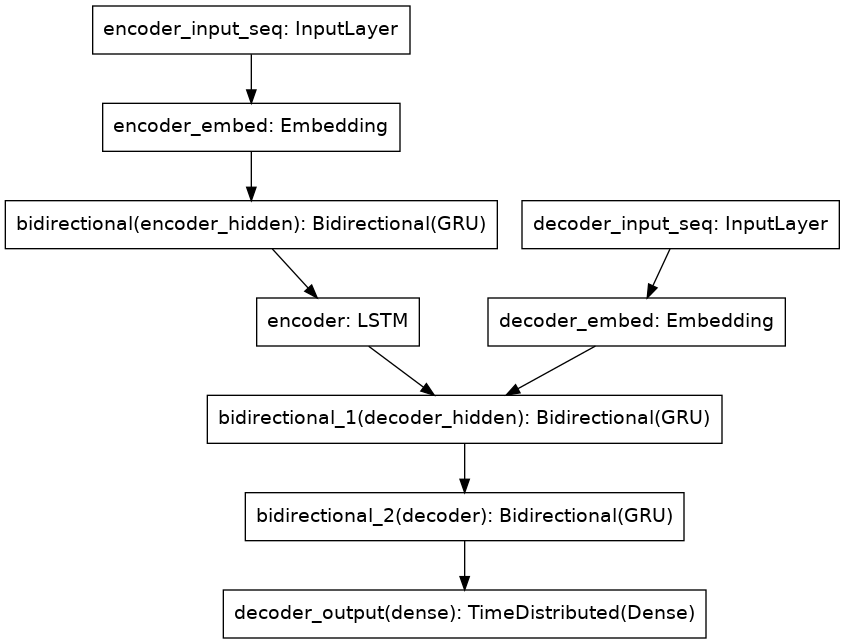

In [14]:
tf.keras.utils.plot_model(enc_dec_model)

In [15]:
X,y=text_id[:-1].reshape(-1,31,1),text_id[1:]
decoder_input_seq = y[:,:-1].reshape(-1,30,1)
decoder_target_seq = y[:,1:].reshape(-1,30,1)

#dataset_X = tf.data.Dataset.from_tensor_slices((X,decoder_input_seq))
#dataset_label = tf.data.Dataset.from_tensor_slices(decoder_target_seq)

#dataset = tf.data.Dataset.zip((dataset_X, dataset_label))
print(X.shape)
#for i in dataset.take(1):
 #   print(i)

(2842477, 31, 1)


In [16]:
#training_elements = int(2842478 * 0.99)
#train_dataset = dataset.take(training_elements)
#validation_dataset = dataset.skip(training_elements)

In [17]:
#train_dataset = train_dataset.batch(256, drop_remainder=True).shuffle(2000)
#validation_dataset = validation_dataset.batch(256)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint('checkpoints_every_epoch/model_{epoch:02d}.h5', save_weights_only = False,save_best_only=False)
early_stop=EarlyStopping(monitor='val_accuracy', patience=2,min_delta=0.001)

In [20]:
history = enc_dec_model.fit([X,decoder_input_seq],y=decoder_target_seq,validation_split=0.01,epochs=20,callbacks=[checkpoint,early_stop],batch_size=256)

Epoch 1/20
10993/10993 [==============================] - 860s 76ms/step - loss: 0.5385 - accuracy: 0.7643 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 2/20
10993/10993 [==============================] - 825s 75ms/step - loss: 4.1540e-04 - accuracy: 0.9999 - val_loss: 1.3096e-04 - val_accuracy: 1.0000
Epoch 3/20
10993/10993 [==============================] - 827s 75ms/step - loss: 1.2169e-04 - accuracy: 1.0000 - val_loss: 1.1695e-04 - val_accuracy: 1.0000


In [22]:
enc_dec_model=tf.keras.models.load_model("/kaggle/working/checkpoints_every_epoch/model_02.h5")

In [23]:
#enc_model.summary()
#print(enc_model.layers[2].get_weights())
#print([layer.name for layer in enc_model.layers])
#print([layer.name for layer in enc_dec_model.layers])
#print(enc_model.layers[2].get_weights()[0][0])
#print(enc_dec_model.layers[3].get_weights()[0][0])

In [24]:
#decoder_model.summary()

In [25]:
test_input=read_data("/kaggle/input/dataset-test/test_input.txt")
print(test_input[:10])
test_id,test_weight=prepare_text_data(test_input,30,vocab)
test_id=np.hstack((np.ones((test_id.shape[0],1)),test_id))
test_id=np.array(test_id,dtype=np.int64)
test_id=test_id.reshape(-1,31,1)

['那一點也不難', '如你所知,"癲狂"這東西', '就好比一股引力', '只需小小的推動,人就飄向那裏了', '登特!', '戈登,你的人接走瑞秋之後', '就是把她帶到了這兒', '她就是在這兒死的', '我知道,當時我也在這兒', '想要救她']


In [69]:
def decode_sequence_with_greedy_search(input_seq):
    enc_state_h, enc_state_c = enc_model.predict(input_seq)
    state_h=enc_state_h
    state_c=enc_state_c
    
    target_seq=np.array([vocab['<BOS>']])
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        y_hat,state_h,state_c = decoder_model.predict([target_seq]+[state_h, state_c])
        # Sample a token
        sampled_token_index = np.argmax(y_hat)
        print(np.argsort(y_hat)[0][0])
        sampled_char = rev_vocab[sampled_token_index]
        decoded_sentence += sampled_char
        
        
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == '<EOS>' or len(decoded_sentence) > 29:
            stop_condition = True
   
        target_seq=np.array([vocab[sampled_char]])

    return decoded_sentence

In [70]:
print(test_input[0])
decode_sequence_with_greedy_search(test_id[0].reshape(-1,31,1))

那一點也不難
[1391 2477 2253 ...  472  490    2]


'<EOS>'

In [73]:
print(test_input[1000])
decode_sequence_with_greedy_search(test_id[9].reshape(-1,31,1))

我不知道上膛了沒
[1391 2477 2253 ...  472  490    2]


'<EOS>'

In [37]:
#test_id[0]